# Barren plateaus

## Overview

Barren plateaus are the greatest difficulties in the gradient-based optimization for a large family of random parameterized quantum circuits (PQC). The gradients vanish almost everywhere. In this example, we will show barren plateaus in quantum neural networks (QNNs).

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

eye = tc.gates.i().tensor
x = tc.gates.x().tensor
y = tc.gates.y().tensor
z = tc.gates.z().tensor

## Parameters

In [2]:
n = 4  # The number of qubits
nlayers = 1  # The number of circuit layers
ncircuits = 2  # The number of circuits with different structures
ntrials = 5  # The number of random circuit instances

## Generating QNN

In [3]:
def op_expectation(params, structures, n, nlayers):
    paramsc = tc.backend.cast(params, dtype="complex128")  # parameters of gates
    structuresc = tc.backend.cast(
        structures, dtype="complex128"
    )  # parameters of circuit structure

    c = tc.Circuit(n)
    for i in range(n):
        c.ry(i, theta=np.pi / 4)
    for l in range(nlayers):
        for i in range(n):
            c.any(
                i,
                unitary=structuresc[i, l, 0]
                * (
                    tc.backend.cos(paramsc[i, l, 0]) * eye
                    + 1.0j * tc.backend.sin(paramsc[i, l, 0]) * x
                )  # Rx
                + structuresc[i, l, 1]
                * (
                    tc.backend.cos(paramsc[i, l, 1]) * eye
                    + 1.0j * tc.backend.sin(paramsc[i, l, 1]) * y
                )  # Ry
                + structuresc[i, l, 2]
                * (
                    tc.backend.cos(paramsc[i, l, 2]) * eye
                    + 1.0j * tc.backend.sin(paramsc[i, l, 2]) * z
                ),  # Rz
            )  # choose one gate from Rx, Ry and Rz gates randomly
        for i in range(n - 1):
            c.cz(i, i + 1)

    return tc.backend.real(
        c.expectation((tc.gates.z(), [0]), (tc.gates.z(), [1]))
    )  # expectations of <Z_0Z_1>

In [4]:
# use vvag to get the expectations of ZZ observable and gradients of different random circuit instances
op_expectation_vvag = tc.backend.jit(
    tc.backend.vvag(op_expectation, argnums=0, vectorized_argnums=1)
)

## Structure parameters

In [5]:
def getstructures(ncircuits, n, nlayers):
    weight = np.random.uniform(low=0.0, high=1.0, size=[ncircuits, n, nlayers, 3])
    maxweightindex = np.argmax(weight, axis=-1)
    structures = np.zeros([ncircuits, n, nlayers, 3])
    for i in range(ncircuits):
        for j in range(n):
            for k in range(nlayers):
                structures[
                    i, j, k, maxweightindex[i, j, k]
                ] = 1.0  # choose the gate with maximal weight
    structures = tc.array_to_tensor(structures, dtype="float64")
    return structures

## Batch variance computation

In [6]:
grad_var_list = []  # gradient variances list
for i in range(ntrials):
    structures = getstructures(ncircuits, n, nlayers)
    params = tc.array_to_tensor(
        np.random.uniform(low=0.0, high=2 * np.pi, size=[n, nlayers, 3]),
        dtype="float64",
    )
    e, grad = op_expectation_vvag(
        params, structures, n, nlayers
    )  # the expectations of ZZ observable and gradients of different random circuits
    grad_var_list.append(tf.math.reduce_std(grad, axis=0)[0, 0])

grad_var = tf.reduce_mean(grad_var_list)
print("The variance of the gradients is:", grad_var.numpy())

The variance of the gradients is: 0.2828084286670117


## Results

The gradient variances in QNNs ($nlayers=50$, $ntrials=20$, $ncircuits=20$). The landscape become exponentially barren with increasing qubit number. 

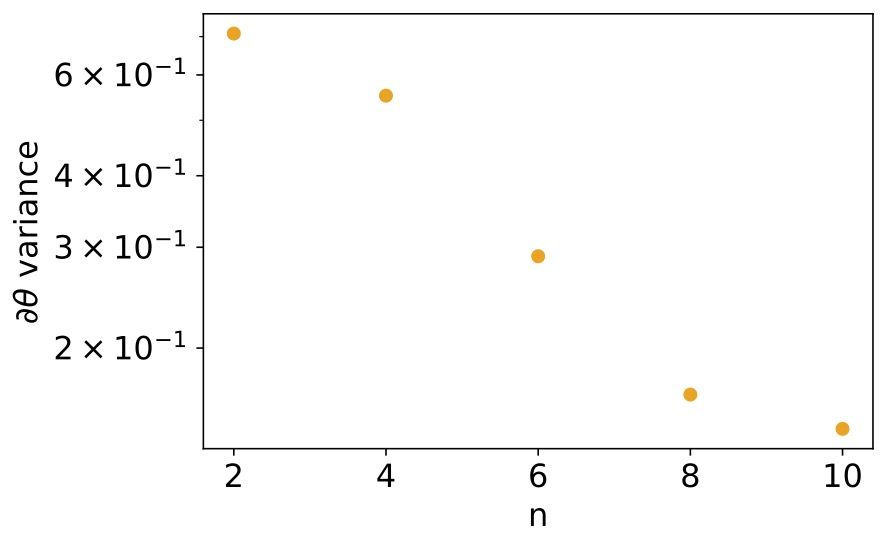